In [1]:
import import_ipynb

import os.path
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from typing import Dict, List, Tuple
from matplotlib.ticker import MaxNLocator
from evaluate_solvers import cost_of_solution
from custom_types import Graph, Solution, Cost
from generate_sample_graphs import deserialize_graphs

importing Jupyter notebook from evaluate_solvers.ipynb
importing Jupyter notebook from generate_sample_graphs.ipynb


In [2]:
if __name__ == "__main__":
  solvers = ["greedy", "nearest_insertion", "cheapest_insertion", "random_insertion", "farthest_insertion"]
  optimizers = ["2-Opt"]
  for opt in optimizers:
    for i in list(range(len(solvers))):
      solvers.append(f"{opt}<{solvers[i]}>")
  evaluations_dir = "evaluations"
  evaluations: Dict[str, List[Tuple[Graph, Solution, Cost]]] = {}
  for solver in solvers:
    evaluations[solver] = []
    path = os.path.join(evaluations_dir, f"{solver}.dat")
    with open(path, "rb") as fp:
      graphs, _ = deserialize_graphs(fp)
    for i in range(0, len(graphs)-1, 2):
      graph = graphs[i]
      solution = graphs[i+1][0]
      evaluations[solver].append((graph, solution, cost_of_solution(graph, solution)))
  
    print(f"{solver}: {len(evaluations[solver])}")


greedy: 10000
nearest_insertion: 10000
cheapest_insertion: 10000
random_insertion: 10000
farthest_insertion: 10000
2-Opt<greedy>: 10000
2-Opt<nearest_insertion>: 10000
2-Opt<cheapest_insertion>: 10000
2-Opt<random_insertion>: 10000
2-Opt<farthest_insertion>: 10000


In [3]:
if __name__ == "__main__":
  data: List[Tuple[str, str, str, int, float]] = []
  for solver in solvers:
    for graph, solution, cost in evaluations[solver]:
      data.append((solver, str(graph), str(solution), len(graph[0]), cost))
  df = pd.DataFrame(data, columns=["Solver", "Graph String", "Solution String", "Num Vertices", "Solution Cost"])
  display.display(df.head())

,Solver,Graph String,Solution String,Num Vertices,Solution Cost
0,greedy,"(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V...","['V9', 'V15', 'V22', 'V0', 'V7', 'V13', 'V14',...",23,3.320887
1,greedy,"(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V...","['V6', 'V14', 'V5', 'V9', 'V3', 'V0', 'V11', '...",25,2.262902
2,greedy,"(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V...","['V5', 'V0', 'V7', 'V6', 'V3', 'V2', 'V10', 'V...",13,2.410629
3,greedy,"(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V...","['V9', 'V3', 'V4', 'V5', 'V7', 'V1', 'V0', 'V6...",10,2.636881
4,greedy,"(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V...","['V9', 'V19', 'V6', 'V11', 'V25', 'V18', 'V0',...",26,2.547420


In [4]:
df["Graph String"].unique().shape

(10000,)

In [5]:
def get_stats(solver: str) -> pd.DataFrame:
  solver_df = df[df["Solver"] == solver]
  median_df = solver_df.groupby("Num Vertices").median(numeric_only=True).rename(columns={"Solution Cost": "Median Solution Cost"})
  uq_df = solver_df.groupby("Num Vertices").quantile(0.75, numeric_only=True).rename(columns={"Solution Cost": "Upper Quartile Solution Cost"})
  lq_df = solver_df.groupby("Num Vertices").quantile(0.25, numeric_only=True).rename(columns={"Solution Cost": "Lower Quartile Solution Cost"})
  min_df = solver_df.groupby("Num Vertices").min(numeric_only=True).rename(columns={"Solution Cost": "Min Solution Cost"})
  max_df = solver_df.groupby("Num Vertices").max(numeric_only=True).rename(columns={"Solution Cost": "Max Solution Cost"})
  stats_df = median_df.join(uq_df).join(lq_df).join(min_df).join(max_df).reset_index()

  stats_df["IQR"] = stats_df["Upper Quartile Solution Cost"] - stats_df["Lower Quartile Solution Cost"]

  return stats_df

if __name__ == "__main__":
  print(solvers[0])
  display.display(get_stats(solvers[0]).head())

greedy


,Num Vertices,Median Solution Cost,Upper Quartile Solution Cost,Lower Quartile Solution Cost,Min Solution Cost,Max Solution Cost,IQR
0,10,2.334763,2.691750,1.972513,0.993846,3.616073,0.719237
1,11,2.341736,2.688209,2.019189,1.022389,4.173364,0.669020
2,12,2.476645,2.836784,2.077097,1.036692,3.948318,0.759687
3,13,2.513561,2.874312,2.148449,1.252175,4.353021,0.725863
4,14,2.534607,2.887032,2.185177,1.086995,4.173084,0.701856


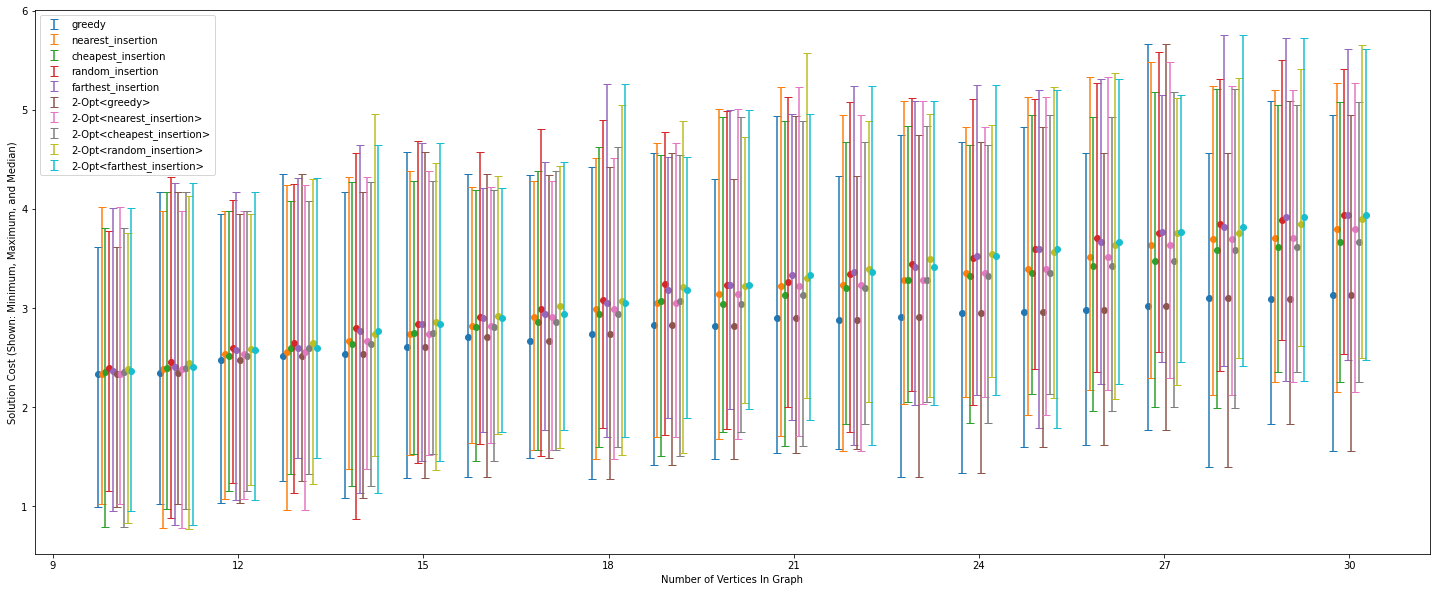

In [6]:
if __name__ == "__main__":
  fig, ax = plt.subplots(figsize=(25, 10))
  width = 0.6
  for i, solver in enumerate(solvers):
    stats_df = get_stats(solver)
    x = stats_df["Num Vertices"] - width/2 + (i+0.5) * width/len(solvers)
    y = stats_df["Median Solution Cost"]
    yerr_low = stats_df["Median Solution Cost"] - stats_df["Min Solution Cost"]
    yerr_high = stats_df["Max Solution Cost"] - stats_df["Median Solution Cost"]
    ax.scatter(x, y)
    ax.errorbar(x, y, (yerr_low, yerr_high), label=solver, ls="none", capsize=4)
    ax.set_xlabel("Number of Vertices In Graph")
    ax.set_ylabel("Solution Cost (Shown: Minimum, Maximum, and Median)")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax.legend()
  

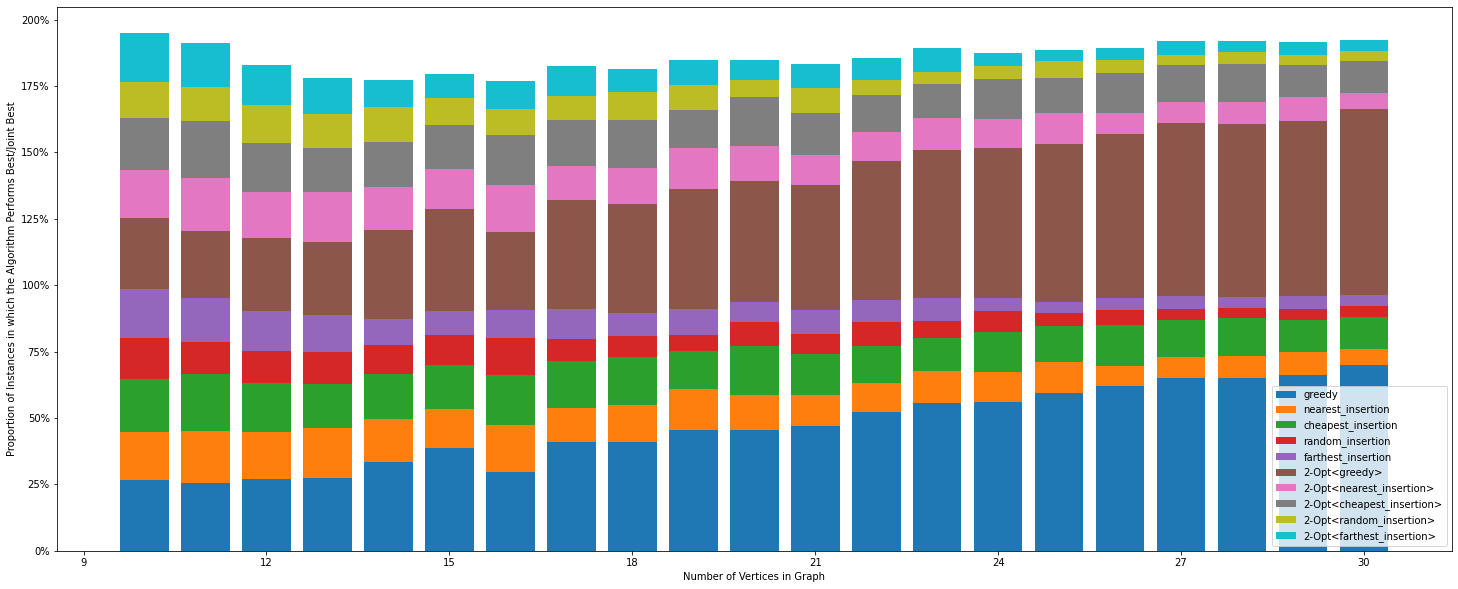

In [7]:
def do_area_chart(solvers_to_ignore: List[str]=[], startx: int=0) -> plt.Figure:
  fig, ax = plt.subplots(figsize=(25, 10))
  dfc = df.groupby("Graph String")["Solution Cost"]
  df_m = df.assign(Min=dfc.transform(min))
  df_m = df_m[df_m["Solution Cost"] == df_m["Min"]]

  row_counts = df.drop_duplicates(subset=["Graph String"]).groupby("Num Vertices").size().to_frame("Count").reset_index().sort_values("Num Vertices").reset_index(drop=True)

  x = row_counts["Num Vertices"]

  data = []
  for solver in solvers:
    if solver in solvers_to_ignore:
      data.append(np.zeros(x.shape))
      continue
    df_where_winner = df_m[df_m["Solver"] == solver].groupby("Num Vertices").size().to_frame("Count").reset_index()
    for i in x:
      if not (df_where_winner["Num Vertices"] == i).any():
        df_where_winner = pd.concat((df_where_winner, pd.DataFrame([[i, 0]], columns=df_where_winner.columns)))

    df_where_winner = df_where_winner.sort_values("Num Vertices").reset_index(drop=True)

    data.append(df_where_winner["Count"]/row_counts["Count"])
  
  bottom = np.zeros(x.shape)
  for i, solver in enumerate(solvers):
    ax.bar(x[startx:], data[i][startx:]*100, bottom=bottom[startx:]*100, label=None if solver in solvers_to_ignore else solver)
    bottom += data[i]
  ax.legend()
  ax.set_xlabel("Number of Vertices in Graph")
  ax.set_ylabel("Proportion of Instances in which the Algorithm Performs Best/Joint Best")
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
  return fig

if __name__ == "__main__":
  do_area_chart()

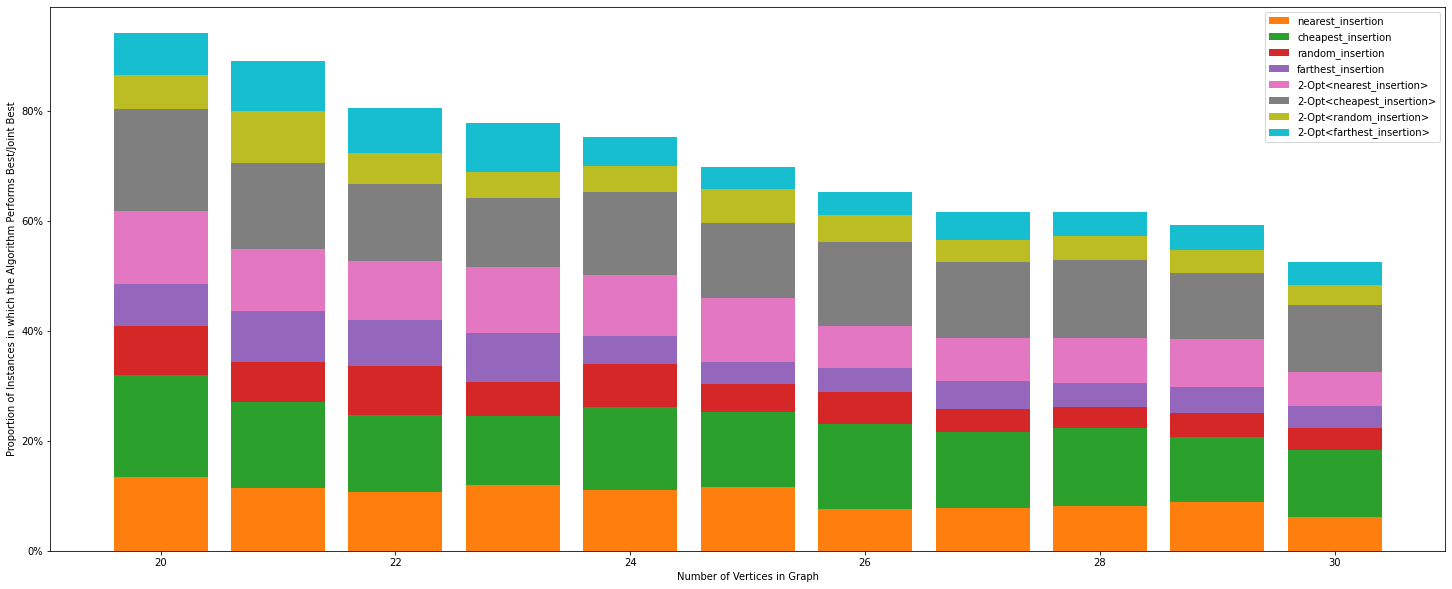

In [8]:
if __name__ == "__main__":
  do_area_chart(solvers_to_ignore=["greedy", "2-Opt<greedy>"], startx=10)